In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
from xgboost import XGBClassifier

df = pd.read_csv("../data/processed/model_ready_data.csv")

In [2]:
X = df.drop(["Churn"], errors="ignore")
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [3]:
model = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, ...)

In [4]:
y_probs = model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_probs)

np.float64(1.0)

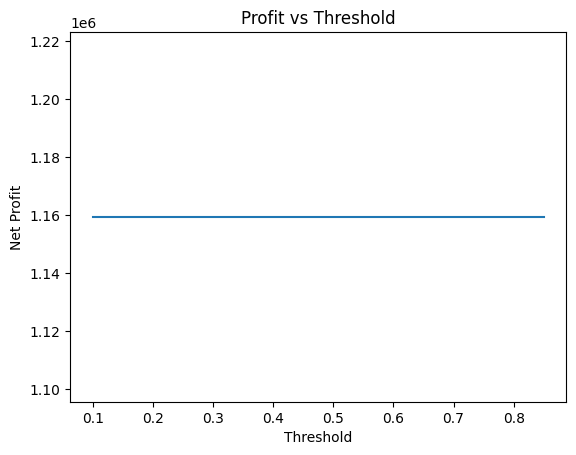

In [5]:
retention_cost = 500
annual_revenue = 6000
save_rate = 0.6

thresholds = np.arange(0.1, 0.9, 0.05)
profits = []

for t in thresholds:
    y_pred = (y_probs >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    saved_revenue = tp * annual_revenue * save_rate
    cost = (tp + fp) * retention_cost
    net_profit = saved_revenue - cost

    profits.append(net_profit)

plt.plot(thresholds, profits)
plt.xlabel("Threshold")
plt.ylabel("Net Profit")
plt.title("Profit vs Threshold")
plt.show()

In [6]:
import joblib
joblib.dump(model, "../models/xgb_churn_model.pkl")

['../models/xgb_churn_model.pkl']

In [7]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
import numpy as np

In [8]:
model = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)

In [9]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    model,
    X,
    y,
    cv=skf,
    scoring="roc_auc"
)

print("CV ROC-AUC scores:", cv_scores)
print("Mean ROC-AUC:", np.mean(cv_scores))

CV ROC-AUC scores: [1. 1. 1. 1. 1.]
Mean ROC-AUC: 1.0


In [10]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "n_estimators": [200, 300, 400, 500],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9]
}

In [11]:
xgb = XGBClassifier(random_state=42, eval_metric="logloss")

random_search = RandomizedSearchCV(
    xgb,
    param_distributions=param_grid,
    n_iter=20,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best Params:", random_search.best_params_)
print("Best ROC-AUC:", random_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Params: {'subsample': 0.9, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.03, 'colsample_bytree': 0.8}
Best ROC-AUC: 1.0


In [12]:
best_model = random_search.best_estimator_

In [13]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

In [14]:
calibrated_model = CalibratedClassifierCV(
    best_model,
    method="isotonic",
    cv=3
)

calibrated_model.fit(X_train, y_train)

calibrated_probs = calibrated_model.predict_proba(X_test)[:, 1]

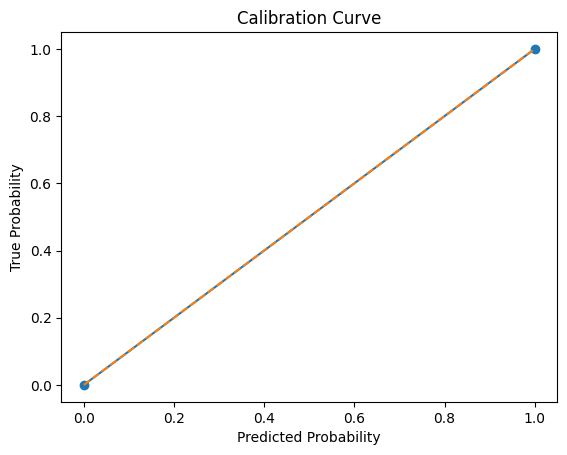

In [16]:
prob_true, prob_pred = calibration_curve(
    y_test,
    calibrated_probs,
    n_bins=10
)

plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve")
plt.show()


In [17]:
X_drifted = X_test.copy()

# Simulate increase in monthly charges
X_drifted["MonthlyCharges"] *= 1.15

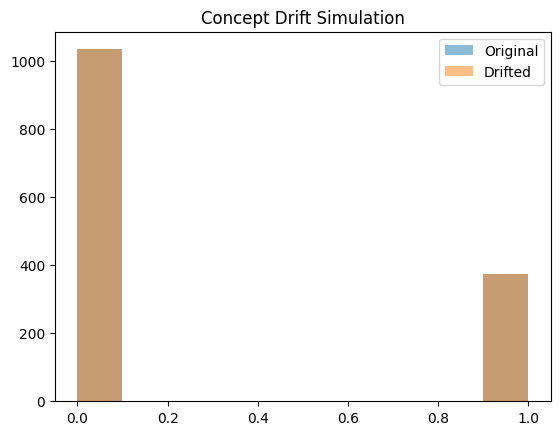

In [19]:
original_probs = best_model.predict_proba(X_test)[:,1]
drifted_probs = best_model.predict_proba(X_drifted)[:,1]

plt.hist(original_probs, alpha=0.5, label="Original")
plt.hist(drifted_probs, alpha=0.5, label="Drifted")
plt.legend()
plt.title("Concept Drift Simulation")
plt.show()


In [20]:
from scipy.stats import ks_2samp

stat, p_value = ks_2samp(original_probs, drifted_probs)

print("KS Statistic:", stat)
print("p-value:", p_value)

KS Statistic: 0.03761533002129169
p-value: 0.27178465680745906


In [21]:
def monitor_model(new_data, model, reference_probs):
    new_probs = model.predict_proba(new_data)[:,1]

    stat, p_value = ks_2samp(reference_probs, new_probs)

    if p_value < 0.05:
        print(" Drift detected")
    else:
        print("Model stable")

    return p_value